In [135]:
import argparse
import time
import queue
from threading import Thread
import json
import logging as log
import os
from pathlib import Path
import random
import sys
import matplotlib.pyplot as plt
from IPython import display

import cv2 as cv

In [136]:
from utils.network_wrappers import Detector, VectorCNN, MaskRCNN, DetectionsFromFileReader
from mc_tracker.mct import MultiCameraTracker
from utils.analyzer import save_embeddings
from utils.misc import read_py_config, check_pressed_keys
from utils.video import MulticamCapture, NormalizerCLAHE
from utils.visualization import visualize_multicam_detections, get_target_size, plot_timeline
from openvino import Core, get_version

sys.path.append(str(Path(os.getcwd()).resolve().parents[2] / 'common/python'))
sys.path.append(str(Path(os.getcwd()).resolve().parents[2] / 'common/python/model_zoo'))
#__file__ -> os.getcwd()
#curDir = os.path.dirname(os.path.abspath(os.getcwd()))
#comDir = os.path.join(curDir, "common/python")
#sys.path.append(comDir)
#comDir2 = os.path.join(curDir, "common/python/model_zoo")
#sys.path.append(comDir2)

import monitors
from model_api.performance_metrics import PerformanceMetrics

log.basicConfig(format='[ %(levelname)s ] %(message)s', level=log.DEBUG, stream=sys.stdout)

In [137]:
def check_detectors(args):
    detectors = {
        '--m_detector': args.m_detector,
        '--m_segmentation': args.m_segmentation,
        '--detections': args.detections
    }
    non_empty_detectors = [(det, value) for det, value in detectors.items() if value]
    det_number = len(non_empty_detectors)
    if det_number == 0:
        log.error('No detector specified, please specify one of the following parameters: '
                  '\'--m_detector\', \'--m_segmentation\' or \'--detections\'')
    elif det_number > 1:
        det_string = ''.join('\n\t{}={}'.format(det[0], det[1]) for det in non_empty_detectors)
        log.error('Only one detector expected but got {}, please specify one of them:{}'
                  .format(len(non_empty_detectors), det_string))
    return det_number


In [138]:
def update_detections(output, detections, frame_number):
    for i, detection in enumerate(detections):
        entry = {'frame_id': frame_number, 'scores': [], 'boxes': []}
        for det in detection:
            entry['boxes'].append(det[0])
            entry['scores'].append(float(det[1]))
        output[i].append(entry)

In [139]:
def save_json_file(save_path, data, description=''):
    save_dir = os.path.dirname(save_path)
    if save_dir and not os.path.exists(save_dir):
        os.makedirs(save_dir)
    with open(save_path, 'w') as outfile:
        json.dump(data, outfile)
    if description:
        log.debug('{} saved to {}'.format(description, save_path))

In [140]:
class FramesThreadBody:
    def __init__(self, capture, max_queue_length=2):
        self.process = True
        self.frames_queue = queue.Queue()
        self.capture = capture
        self.max_queue_length = max_queue_length

    def __call__(self):
        while self.process:
            if self.frames_queue.qsize() > self.max_queue_length:
                time.sleep(0.1)
                continue
            has_frames, frames = self.capture.get_frames()
            if not has_frames and self.frames_queue.empty():
                self.process = False
                break
            if has_frames:
                self.frames_queue.put(frames)

In [141]:
def run(params, config, capture, detector, reid):
    win_name = 'Multi camera tracking'
    frame_number = 0
    output_detections = [[] for _ in range(capture.get_num_sources())]
    key = -1

    if config.normalizer_config.enabled:
        capture.add_transform(
            NormalizerCLAHE(
                config.normalizer_config.clip_limit,
                config.normalizer_config.tile_size,
            )
        )

    tracker = MultiCameraTracker(capture.get_num_sources(), reid, config.sct_config,
                                 **vars(config.mct_config), visual_analyze=config.analyzer)

    thread_body = FramesThreadBody(capture, max_queue_length=len(capture.captures) * 2)
    frames_thread = Thread(target=thread_body)
    frames_thread.start()

    frames_read = False
    set_output_params = False

    prev_frames = thread_body.frames_queue.get()
    detector.run_async(prev_frames, frame_number)
    metrics = PerformanceMetrics()
    presenter = monitors.Presenter(params.utilization_monitors, 0)
    while thread_body.process:
        if not params.no_show:
            key = check_pressed_keys(key)
            if key == 27:
                cv.destroyAllWindows()
                break
            presenter.handleKey(key)
        start_time = time.perf_counter()
        try:
            frames = thread_body.frames_queue.get_nowait()
            frames_read = True
        except queue.Empty:
            frames = None

        if frames is None:
            continue

        all_detections = detector.wait_and_grab()
        if params.save_detections:
            update_detections(output_detections, all_detections, frame_number)
        frame_number += 1
        detector.run_async(frames, frame_number)

        all_masks = [[] for _ in range(len(all_detections))]
        for i, detections in enumerate(all_detections):
            all_detections[i] = [det[0] for det in detections]
            all_masks[i] = [det[2] for det in detections if len(det) == 3]

        tracker.process(prev_frames, all_detections, all_masks)
        tracked_objects = tracker.get_tracked_objects()

        ###### check people and drawing graph..
        if frame_number%5==0:
            x.append(frame_number)
            ##### use more video have to change 
            y1.append(len(tracked_objects[0])+len(tracked_objects[1]))
            plt.plot(x[:(frame_number-1)], y1[:(frame_number-1)])
            plt.show()
        plt.title('check people')
        plt.xlabel('timeline')
        plt.ylabel('people')
        display.clear_output(wait=True)
        
        vis = visualize_multicam_detections(prev_frames, tracked_objects,
                                            **vars(config.visualization_config))
        metrics.update(start_time, vis)
        presenter.drawGraphs(vis)
        if not params.no_show:
            cv.imshow(win_name, vis)

        if frames_read and not set_output_params:
            set_output_params = True
            if len(params.output_video):
                frame_size = [frame.shape[1::-1] for frame in frames]
                fps = capture.get_fps()
                target_width, target_height = get_target_size(
                    frame_size, None, **vars(config.visualization_config))
                video_output_size = (target_width, target_height)
                fourcc = cv.VideoWriter_fourcc(*'XVID')
                output_video = cv.VideoWriter(params.output_video, fourcc, min(fps), video_output_size)
            else:
                output_video = None
        if set_output_params and output_video:
            output_video.write(cv.resize(vis, video_output_size))

        prev_frames, frames = frames, prev_frames
    metrics.log_total()
    for rep in presenter.reportMeans():
        log.info(rep)

    thread_body.process = False
    frames_thread.join()

    if len(params.history_file):
        save_json_file(params.history_file, tracker.get_all_tracks_history(), description='History file')
    if len(params.save_detections):
        save_json_file(params.save_detections, output_detections, description='Detections')

    if len(config.embeddings.save_path):
        save_embeddings(tracker.scts, **vars(config.embeddings))
    detector.infer_queue.wait_all()

[ INFO ] Metrics report:
[ INFO ] 	Latency: 42.3 ms
[ INFO ] 	FPS: 20.0


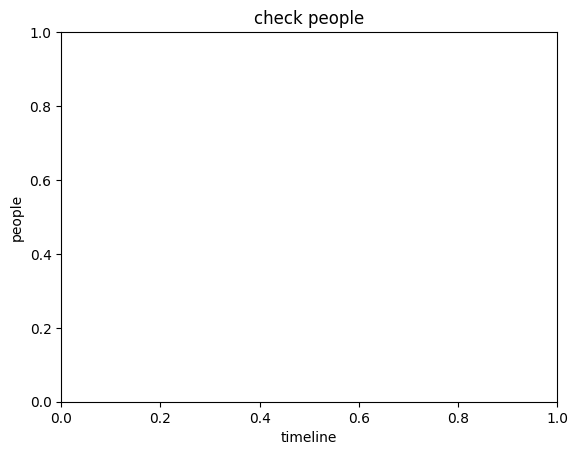

In [143]:
def main():
    current_dir = os.path.dirname(os.path.abspath(os.getcwd()))
    """Prepares data for the object tracking demo"""
    parser = argparse.ArgumentParser(description='Multi camera multi object \
                                                  tracking live demo script')
    parser.add_argument('-i','--input', required=False, nargs='+',
                        help='Required. Input sources (indexes of cameras or paths to video files)')
    parser.add_argument('--loop', default=False, action='store_true',
                        help='Optional. Enable reading the input in a loop')
    parser.add_argument('--config', type=str, default=os.path.join(current_dir, 'configs/person.py'), required=False,
                        help='Configuration file')

    parser.add_argument('--detections', type=str, help='JSON file with bounding boxes')

    parser.add_argument('--m_detector', type=str, required=False,
                        help='Path to the object detection model')
    parser.add_argument('--t_detector', type=float, default=0.6,
                        help='Threshold for the object detection model')

    parser.add_argument('--m_segmentation', type=str, required=False,
                        help='Path to the object instance segmentation model')
    parser.add_argument('--t_segmentation', type=float, default=0.6,
                        help='Threshold for object instance segmentation model')

    parser.add_argument('--m_reid', type=str, required=False,
                        help='Required. Path to the object re-identification model')

    parser.add_argument('--output_video', type=str, default='', required=False,
                        help='Optional. Path to output video')
    parser.add_argument('--history_file', type=str, default='', required=False,
                        help='Optional. Path to file in JSON format to save results of the demo')
    parser.add_argument('--save_detections', type=str, default='', required=False,
                        help='Optional. Path to file in JSON format to save bounding boxes')
    parser.add_argument("--no_show", help="Optional. Don't show output", action='store_true')

    parser.add_argument('-d', '--device', type=str, default='CPU')
    parser.add_argument('-u', '--utilization_monitors', default='', type=str,
                        help='Optional. List of monitors to show initially.')

    src = ['./video_1.mp4', './video_2.mp4']
    args = parser.parse_args('')
    args.input = src
    args.config = './configs/person.py'
    args.m_detector = './intel/person-detection-retail-0013/FP16/person-detection-retail-0013.xml' 
    args.m_reid = './intel/person-reidentification-retail-0277/FP16/person-reidentification-retail-0277.xml'
    print(args)
    if check_detectors(args) != 1:
        sys.exit(1)

    if len(args.config):
        log.debug('Reading config from {}'.format(args.config))
        config = read_py_config(args.config)
    else:
        log.error('No configuration file specified. Please specify parameter \'--config\'')
        sys.exit(1)

    random.seed(config.random_seed)
    capture = MulticamCapture(args.input, args.loop)

    log.info('OpenVINO Runtime')
    log.info('\tbuild: {}'.format(get_version()))
    core = Core()

    if args.detections:
        object_detector = DetectionsFromFileReader(args.detections, args.t_detector)
    elif args.m_segmentation:
        object_detector = MaskRCNN(core, args.m_segmentation,
                                   config.obj_segm.trg_classes,
                                   args.t_segmentation,
                                   args.device,
                                   capture.get_num_sources())
    else:
        object_detector = Detector(core, args.m_detector,
                                   config.obj_det.trg_classes,
                                   args.t_detector,
                                   args.device,
                                   capture.get_num_sources())

    if args.m_reid:
        object_recognizer = VectorCNN(core, args.m_reid, args.device)
    else:
        object_recognizer = None

    run(args, config, capture, object_detector, object_recognizer)


if __name__ == '__main__':
    x=[]
    y1=[]
    main()
